# Summary

This notebook serves as the testing environment of training the actor-critic model for preconditioner learning.

## TODO:
1. LOTS

# Imports/Setup

In [1]:
from Data import critic_dataset, dataset, generator
from Data import utility as data_utility
from Model import critics, actors, scipy, ac_training
from Model import utility as model_utility
from Evaluation import utility as eval_utility
from Objectives import losses, reward
import torch
import random
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from collections import deque
import numpy as np

/data/users/jupyter-dam724/.local/lib/python3.9/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /data/users/jupyter-dam724/.local/lib/python3.9/site-packages/libpyg.so: undefined symbol: _ZN3c1010Dispatcher17runRecordFunctionERN2at14RecordFunctionESt17reference_wrapperIKNS_14FunctionSchemaEENS_11DispatchKeyE
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/data/users/jupyter-dam724/.local/lib/python3.9/site-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /data/users/jupyter-dam724/.local/lib/python3.9/site-packages/torch_cluster/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/data/users/jupyter-dam724/.local/lib/python3.9/site-packages/torch_geometric/typing.py:113: UserWarning: An issue occurred whil

# Configuration

In [2]:
class Config:
    # dataset
    device_pref = 'cuda'
    ind_dev = 2
    batch_size = 32
    n = 25
    train_len = 1000
    batch_size = 32
    gen_size = 5
    valid_len = 100
    shuffle = True

    # critic model
    pretrained_critic = '/data/users/jupyter-dam724/RL/precondition-discovery-contextual-bandit/RUNS/critic_sigmoid_smaller.pth'
    # pretrained_critic = '/data/users/jupyter-dam724/RL/precondition-discovery-contextual-bandit/RUNS/critic_niter_smaller.pth'
    # pretrained_critic = None
    
    down = 256  # if this is changed, model architecture should be changed as well
    sigmoid = True
    sparse, niter, res = 1.0, 1.0, 1.0
    switch_up = False
    multi = False
    
    # actor model
    pretrained_actor = None
    hidden = 256 # 128 for LU (it doubles the amount of layers) | 512 for NID it has larger output same layers | 256 else
    sparse_tol = 1e-3
    diagonal_bias = 0.1
    tanh = False
    sig = True
    
    l1 = 0
    inv = 0
    dev = 0
    cond = 1.0
    
    # training
    epoches = 100
    memory = 32*250
    wait = 64
    lr = 1e-5
    verbose = True

# Device

In [3]:
device = data_utility.set_device(Config.device_pref, Config.ind_dev)

Now using GPU.


# Critic

...

In [4]:
critic_params = {
    'n': Config.n, 
    'down': Config.down, 
    'batch_size': Config.batch_size, 
    'sigmoid_scale': Config.sigmoid
}

critic = critics.SmallerSingleCritic(**critic_params).to(device)

if Config.pretrained_critic is not None:
     model_utility.load_model(critic, Config.pretrained_critic)

## Cirtic Objective

...

In [5]:
reward_func = reward.batched_reward(Config.n, False, Config.switch_up)

In [6]:
if Config.multi:
    critic_crit = losses.CriticMultiRewardLoss(Config.sparse, Config.niter, Config.res, reward_func)
else:
    critic_crit = losses.CriticSingleRewardLoss(Config.sparse, Config.niter, Config.res, reward_func)

# Actor

...

In [7]:
actor_params = {
    'n':Config.n,
    'hidden':Config.hidden,
    'batch_size':Config.batch_size,
    'sparse_tol':Config.sparse_tol,
    'diagonal_bias':Config.diagonal_bias,
    'tanh': Config.tanh,
    'sig': Config.sig
}

actor = actors.CholeskyFCN(**actor_params).to(device)

if Config.pretrained_actor is not None:
     model_utility.load_model(actor, Config.pretrained_actor)

# Actor (Additional) Objective

...

In [8]:
loss_params = {
    'l1': Config.l1,
    'inv': Config.inv,
    'dev': Config.dev,
    'cond': Config.cond,
    'batch_size': Config.batch_size,
    'size': Config.n
}

actor_crit = losses.CondEyeDistance(**loss_params)

# Dataset

...

In [9]:
train_dataset_params = {
    'generator': generator.generate_2d_diffusion_spd,
    'norm_feat': data_utility.normalize_features,
    'epoch_len': Config.train_len,
    'batch_size': Config.batch_size,
    'size': Config.gen_size
}

valid_dataset_params = {
    'generator': generator.generate_2d_diffusion_spd,
    'norm_feat': data_utility.normalize_features,
    'epoch_len': Config.valid_len,
    'batch_size': Config.batch_size,
    'size': Config.gen_size
}

train_dataset = dataset.SystemDataset(**train_dataset_params)
valid_dataset = dataset.SystemDataset(**valid_dataset_params)

In [10]:
train_dataloader_params = {
    'dataset': train_dataset,
    'batch_size': Config.batch_size,
    'shuffle': Config.shuffle
}

valid_dataloader_params = {
    'dataset': valid_dataset,
    'batch_size': Config.batch_size,
    'shuffle': Config.shuffle
}

train_dataloader = dataset.get_dataloader(**train_dataloader_params)
valid_dataloader = dataset.get_dataloader(**valid_dataloader_params)

In [11]:
A, b = next(iter(train_dataloader))

Determinent: 331528192.0
Matrix is non-singular.
Condition: 3981.111572265625
SPD


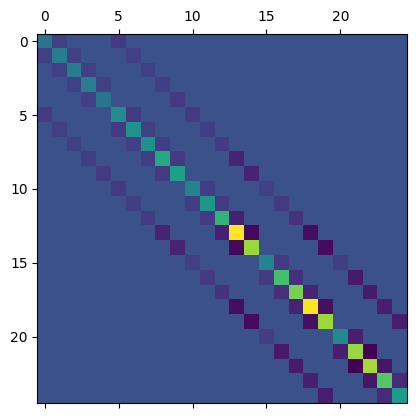

In [12]:
ind = 0
fig, ax = plt.subplots(1, 1)

data_utility.check_singularity(A, ind)
data_utility.check_conditioning(A, ind)
data_utility.view_matrix(A, ind, ax)
print('SPD') if data_utility.is_spd(A, ind) else print('Non-SPD')

# DDPG (Contextual Bandits)

...

In [13]:
def structured_preconditioner_noise(action):
    # Randomly select strength in the range [0, 0.5] if not provided
    strength = random.uniform(0.1, 0.5)

    noise = torch.randn_like(action).to(action.device)
    symmetric_noise = (noise + torch.transpose(noise, 1, 2)) / 2
    return action + symmetric_noise * strength

In [14]:
def symmetric_sparsity(action):
    batch_size, n, _ = action.size()

    # Generate a random mask for one matrix
    random_mask = torch.rand((n, n), device=action.device) < 0.5
    symmetric_mask = torch.triu(random_mask, diagonal=1) + torch.triu(random_mask, diagonal=1).T

    # Expand mask for the batch
    symmetric_mask = symmetric_mask.unsqueeze(0).expand(batch_size, -1, -1)

    # Apply the mask to the input tensor
    action = action.clone()  # Clone to avoid modifying the input tensor
    action[symmetric_mask] = 0

    return action

In [15]:
class CosineScheduler:
    def __init__(self, max_value, min_value, total_steps, phase_shift=0):
        self.max_value = max_value
        self.min_value = min_value
        self.total_steps = total_steps
        self.phase_shift = phase_shift
        self.step = 0

    def get_value(self):
        progress = torch.tensor(self.step / self.total_steps, dtype=torch.float32)
        # Compute cosine value with phase shift
        cosine_value = 0.5 * (1 + torch.cos(2 * torch.pi * progress + self.phase_shift))
        # Scale to the range [min_value, max_value]
        return self.min_value + cosine_value * (self.max_value - self.min_value)

    def step_forward(self):
        self.step += 1

In [16]:
total_steps = 75
condition_scheduler = CosineScheduler(max_value=0.9, min_value=0.05, total_steps=total_steps, phase_shift=0)
noise_scheduler = CosineScheduler(max_value=0.9, min_value=0.05, total_steps=total_steps, phase_shift=6)

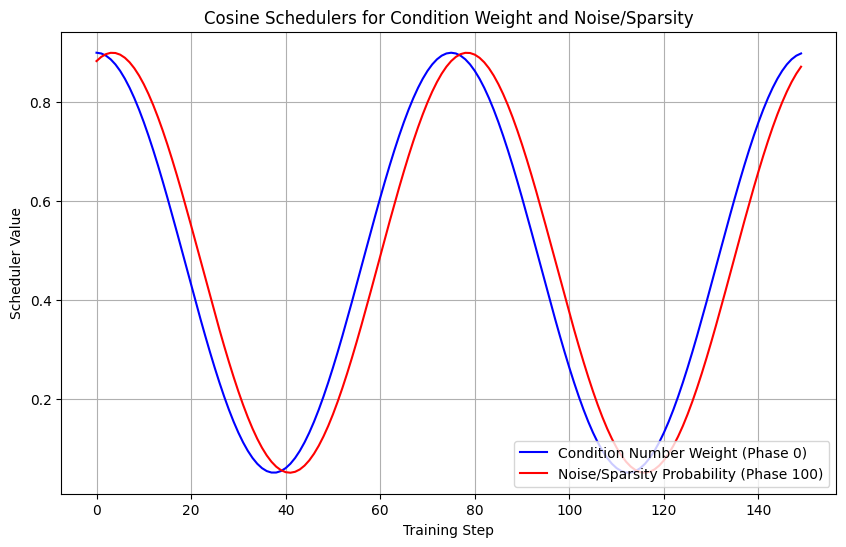

In [17]:
condition_values = []
noise_values = []

for i in range(total_steps*2):
    condition_values.append(condition_scheduler.get_value())
    noise_values.append(noise_scheduler.get_value())
    condition_scheduler.step_forward()
    noise_scheduler.step_forward()
    
plt.figure(figsize=(10, 6))
plt.plot(condition_values, label="Condition Number Weight (Phase 0)", color="blue")
plt.plot(noise_values, label="Noise/Sparsity Probability (Phase 100)", color="red")
plt.title("Cosine Schedulers for Condition Weight and Noise/Sparsity")
plt.xlabel("Training Step")
plt.ylabel("Scheduler Value")
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [18]:
def step(epoch, timestep, actor, critic, batch, critic_crit, actor_crit, buffer, 
         wait, critic_optimizer, actor_optimizer, verbose, condition_weight, exploration_prob):

    A, b = batch  # A: state, b: reward
    A, b = A.to(device), b.to(device)
    batch_size, n_size = A.shape[0], A.shape[1]
    A = A.view(batch_size, n_size**2)
    
    critic_update_item, actor_loss_item = 0, 0
    
    model_utility.freeze(critic)
    
    # Generate action
    actor_out = actor(A).view(batch_size, n_size, n_size)
    
    if random.uniform(0.0, 1.0) < exploration_prob:
        actor_out = structured_preconditioner_noise(actor_out) # add symmetric noise to action
    if random.uniform(0.0, 1.0) < exploration_prob:
        actor_out = symmetric_sparsity(actor_out) # add random sparsity
        
    actor_out = actor_out.view(batch_size, n_size**2)
    
    # Add to replay buffer    
    random_index = random.randint(0, 31)
    buffer.append((
        A[random_index].cpu(), 
        actor_out[random_index].detach().cpu(), 
        b[random_index].cpu()
    ))
    
    # Critic Training (periodically)
    if len(buffer) > 32 and timestep % wait == 0:
        critic_optimizer.zero_grad()
        actor_optimizer.zero_grad()

        model_utility.freeze(critic)
        
        # Sample from replay buffer
        A_samples, M_samples, b_samples = zip(*random.sample(buffer, 32))
        A, M, b = (
            torch.stack(A_samples).to(device), 
            torch.stack(M_samples).to(device), 
            torch.stack(b_samples).to(device)
        )

        # Generate action
        actor_out = actor(A)
        # actor_out = structured_preconditioner_noise(actor_out)  # add noise to action
        actor_out = actor_out.view(batch_size, n_size**2)
        actor_loss = 0

        # Actor loss: maximize expected reward 
        # Combine state and generated action to get reward prediction
        critic_input = torch.cat([A, actor_out], dim=1)
        
        # force no critic
        if Config.multi:
            actor_loss = 1 * (-critic(critic_input) @ torch.Tensor([Config.sparse, Config.niter, Config.res]).to(device)).mean()
        else:
            actor_loss = 1 * -critic(critic_input).mean()

        # Optional additional actor criterion
        # TEMP CHANGE
        if actor_crit is not None:
            actor_loss += condition_weight * actor_crit(
                A.view(batch_size, n_size, n_size), 
                actor_out.view(batch_size, n_size, n_size)
            )
            
        if timestep % 500 == 0:
            save_path = f"/data/users/jupyter-dam724/RL/precondition-discovery-contextual-bandit/RUNS_10/actor_output_step_{epoch}_{timestep}.pth"
            torch.save({
                "timestep": timestep,
                "actor_out": actor_out.detach().cpu(),
                "critic_input": critic_input.detach().cpu(),
                "actor_loss": actor_loss.item(),
            }, save_path)
            
        actor_loss_item = actor_loss.item()

        actor_loss.backward()
        torch.nn.utils.clip_grad_norm_(actor.parameters(), max_norm=1.0)
        actor_optimizer.step()

        # Critic loss (predicting immediate reward)
        if timestep % wait == 0:
            model_utility.unfreeze(critic)
            
            critic_input = torch.cat([A, M], dim=1)
            predicted_rewards = critic(critic_input)

            if Config.multi:
                sparsity  = predicted_rewards[:, 0].view(batch_size, 1)
                niter = predicted_rewards[:, 1].view(batch_size, 1)
                residuals = predicted_rewards[:, 2].view(batch_size, 1)

                critic_update = critic_crit(
                    sparsity, niter, residuals, 
                    A.view(batch_size, n_size, n_size), 
                    M.view(batch_size, n_size, n_size), b
                )

            else:
                critic_update = critic_crit(
                    predicted_rewards, 
                    A.view(batch_size, n_size, n_size), 
                    M.view(batch_size, n_size, n_size), b
                )

            critic_update_item = critic_update.item()

            critic_update.backward()
            torch.nn.utils.clip_grad_norm_(critic.parameters(), max_norm=1.0)
            critic_optimizer.step()
        
    return actor_loss_item, critic_update_item

In [19]:
# comment out the buffer if rerunning
buffer = deque(maxlen=10000)

In [20]:
train_log, valid_log = [], []

ddpg_params = {
    'epoches': 2500,
    'actor': actor,
    'critic': critic,
    'train_set': train_dataloader,
    'valid_set': valid_dataloader,
    'device': device,
    'train_log': train_log,
    'valid_log': valid_log,
    'critic_crit': critic_crit,
    'actor_crit': actor_crit,
    'actor_lr': 1e-6,
    'critic_lr': 1e-6,
    'memory': 100000, 
    'wait': 32,
    'step': step,
    'verbose': False,
    'buffer': buffer,
    'condition_scheduler': condition_scheduler,
    'noise_scheduler': noise_scheduler,
    'opts': None
}

# MAKE SURE TO SAVE THE TRAIN PLOT

buffer, condition_scheduler, noise_scheduler, actor_optim, critic_optim = ac_training.train_experimental(**ddpg_params)

Epoch 0/2500: Actor=1.0729878540039062, Critic=2.515856643676758
Epoch 1/2500: Actor=1.1311560440063477, Critic=2.521257278442383
Epoch 2/2500: Actor=1.1634131546020507, Critic=2.3531436004638673
Epoch 5/2500: Actor=1.1824004135131836, Critic=1.972685131072998
Epoch 6/2500: Actor=1.1635047340393065, Critic=1.8282435150146485
Epoch 7/2500: Actor=1.151815887451172, Critic=1.6950932693481446
Epoch 8/2500: Actor=1.1184145393371583, Critic=1.5611716346740723
Epoch 9/2500: Actor=1.1038618583679198, Critic=1.3952666664123534
Epoch 10/2500: Actor=1.0676722679138184, Critic=1.2758353309631347
Epoch 11/2500: Actor=1.0269025955200195, Critic=1.1349886112213134
Epoch 12/2500: Actor=0.9953134765625, Critic=1.027138261795044
Epoch 13/2500: Actor=0.9559692268371582, Critic=0.8678953018188477
Epoch 14/2500: Actor=0.9144085731506347, Critic=0.7382196464538574
Epoch 15/2500: Actor=0.8681040306091309, Critic=0.6349682674407959
Epoch 16/2500: Actor=0.8186740188598632, Critic=0.5469220457077026
Epoch 17/25

In [23]:
model_utility.save_model(critic, '/data/users/jupyter-dam724/RL/precondition-discovery-contextual-bandit/RUNS_10/model_9.pth')
model_utility.save_model(actor, '/data/users/jupyter-dam724/RL/precondition-discovery-contextual-bandit/RUNS_10/model_9.pth')

In [24]:
save_path = "model_chpt_9.pth"

# Create a dictionary to save the components
save_dict = {
    "buffer": buffer,  # Assuming buffer is a list or similar object
    "condition_scheduler": {
        'max_value': condition_scheduler.max_value,
        'min_value': condition_scheduler.min_value,
        'total_steps': condition_scheduler.total_steps,
        'phase_shift': condition_scheduler.phase_shift,
        'step': condition_scheduler.step
    },
    "noise_scheduler": {
        'max_value': noise_scheduler.max_value,
        'min_value': noise_scheduler.min_value,
        'total_steps': noise_scheduler.total_steps,
        'phase_shift': noise_scheduler.phase_shift,
        'step': noise_scheduler.step
    },
    "actor_optimizer": actor_optim.state_dict(),
    "critic_optimizer": critic_optim.state_dict(),
    'actor': actor.state_dict(),
    'critic': critic.state_dict()
}

# Save the dictionary using torch.save
torch.save(save_dict, save_path)
print(f"Checkpoint saved at {save_path}")

Checkpoint saved at cos_trained_lu_nocond_chpt_1.pth


In [ ]:
plot_training_params = {
    'train_log': train_log,
    'valid_log': valid_log,
    'title': 'Condition/Critic Cosine Scheduled', 
    'file_path': 'model_5.png'
}
eval_utility.plot_training(**plot_training_params)